In [2]:
import pandas as pd 

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import xgboost as xgb

import scikitplot as skplt

In [3]:
df = pd.read_csv('./data/authority_dataset.csv').rename(columns={'auth': 'authority'})
df

,ad,authority
0,north korea officially has no corona cases how...,1
1,it seems difficult to stand for something one ...,0
2,senator bernie sanders held a rally with randy...,1
3,life gets busy—don’t wait to send back your ba...,0
4,some issues feel impossible to compromise on b...,1
...,...,...
49661,a recent poll shows sherrod with just a one po...,0
49662,today’s donor goal ⃣ ⃣ ⃣ our endofquarter dead...,0
49663,you’ve been selected after a year of chaos hat...,1
49664,after receiving the corona vaccine a video tha...,0


In [4]:
X_train, X_test, y_train,  y_test = train_test_split(df['ad'], df['authority'] , test_size = 0.33, random_state = 42)

In [5]:
tf_vectorizer = TfidfVectorizer() 

X_train_tf = tf_vectorizer.fit_transform(X_train)
X_test_tf = tf_vectorizer.transform(X_test)

In [6]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train_tf, y_train)

C:\Users\elfraiha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:39:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

accuracy:   0.974
              precision    recall  f1-score   support

no-authority       0.95      1.00      0.97      8190
   authority       1.00      0.95      0.97      8200

    accuracy                           0.97     16390
   macro avg       0.98      0.97      0.97     16390
weighted avg       0.98      0.97      0.97     16390

confusion matrix:
[[8183    7]
 [ 417 7783]]



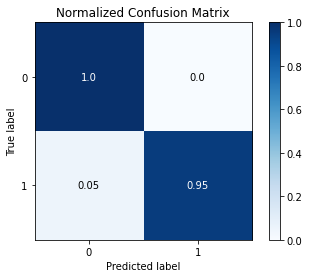

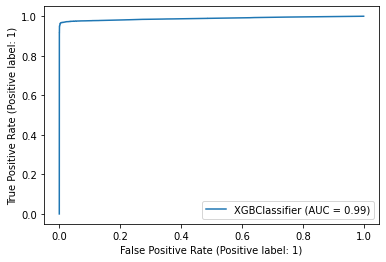

In [46]:
# predict the labels on validation dataset
predictions = xgb_clf.predict(X_test_tf)

# compute the performance measures
score1 = metrics.accuracy_score(y_test, predictions)
print("accuracy:   %0.3f" % score1)

print(metrics.classification_report(y_test, predictions, target_names=['no-authority', 'authority']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.show()
svc_disp = metrics.RocCurveDisplay.from_estimator(xgb_clf, X_test_tf, y_test)

In [7]:
df_val = pd.read_csv('./data/sample_auth.csv')
df_val

,ad,authority
0,How are health and climate change connected?Wa...,1
1,Crime is on the rise in California. Hear a cri...,1
2,Researchers at QIMR Berghofer are conducting a...,1
3,Hear a policy expert discuss how Prop 12 will ...,1
4,"As Toronto’s former chief of police, Mark Saun...",1
...,...,...
195,Families are often the foundation of a strong ...,0
196,Proven leadership you can count on. With nearl...,1
197,"If elected, the Ontario Liberals will implemen...",1
198,"If elected, the Ontario Liberals will implemen...",1


accuracy:   0.755
              precision    recall  f1-score   support

     no-auth       0.73      0.81      0.77       102
        auth       0.78      0.69      0.74        98

    accuracy                           0.76       200
   macro avg       0.76      0.75      0.75       200
weighted avg       0.76      0.76      0.75       200

confusion matrix:
[[83 19]
 [30 68]]



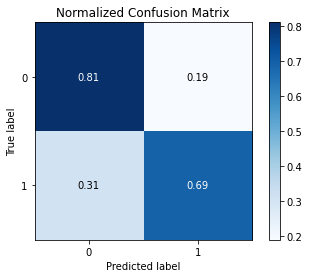

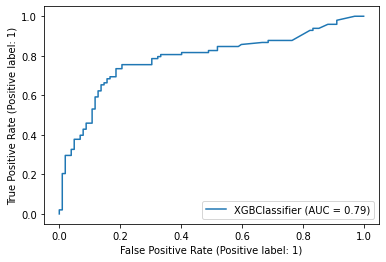

In [8]:
X_val = tf_vectorizer.transform(df_val['ad'])
y_val = df_val['authority']
y_pred = xgb_clf.predict(X_val)

score = metrics.accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_val, y_pred, target_names=[ 'no-auth', 'auth']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(xgb_clf, X_val, y_val)